# Disease Outbreak Predictor
**Course**: CPE 3018 - Numerical Methods <br>
**Class Schedule:**: TTh 3:00 PM - 4:30 PM
**Instructor**: Engr. Alvin Joseph Macapagal <br>
**Members**: Abatayo, Johanssen; Linga, Jevana Cielo; Sarcol, Joshua

**Overview** <br>
This notebook implements a disease outbreak predictor based on Newton's Divided Difference Method. It:
1. Uses a small number of time-based data points (days vs. cases/deaths).
2. Builds an approximating polynomial using divided differences.
3. Performs:
     - Interpolation (estimating missing data within the time range).
     - Extrapolation (estimating future cases beyond the time range).
4. Provides plots which shows the:
    - Observed data
    - Approximating polynomial curve through the provided data
    - Interpolated missing data
    - Extrapolated future predictions

Start by clicking on the **"Run All" button**, which should automatically run all of the code cells and print out their subsequent outputs. <br>
You may also view the __Outline/Table of Contents__ to quickly skim through the contents of the notebook.

## 0. Project Setup

This section initializes all required libraries used in the system.
NumPy is used for numerical computation, Pandas for data handling and
tabular representation, and Matplotlib for visualizing outbreak trends.

- **NumPy**: numerical computation and arrays.
- **Pandas**: tabular data handling and display.  
- **Matplotlib**: plotting observed and predicted outbreak trends.  
- **Warnings**: suppress non-critical warnings to improve readability.  

In [23]:
# Import libraries
import numpy as np                  # For numerical computations, arrays, math
import pandas as pd                 # For tabular display and basic data manipulation
import matplotlib.pyplot as plt     # For plotting and visualization
import warnings

# Suppress non-critical warnings
warnings.filterwarnings('ignore')

# Improve output readability
np.set_printoptions(precision=6, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

If you see a ModuleNotFoundError error, it most likely means that the package is not installed in your system. <br>
This will cause the entire notebook to not run! <br> <br>

Use the python package manager to install missing packages with the following terminal command:
> pip install _package_

## 1. Class Implementations

### 1.1 Divided Difference Method Implementation
**Class:** `NewtonDividedDifference` 
This class implements the Divided Difference method with Newton polynomials. It constructs a polynomial that passes through all observed data points and
allows estimation of values through interpolation and extrapolation. <br>

Contains the following methods: <br>
> **_comp_dd**: Constructs the divided differences table <br>
> **evaluate**: Evaluates the resulting interpolating polynomial for any x (interpolation or extrapolation) <br>
> **show_ddTable**: Provides a console printout of the divided differences table <br>

In [24]:
class NewtonDividedDifference:
    """
    Newton's Divided Difference Interpolation Method

    Attributes:
        x_data (np.array): Time points (independent variable)
        y_data (np.array): Case/death counts (dependent variable)
        n (int): Number of data points
        dd_table (np.array): 2D array of divided differences
    """

    def __init__(self, x_data, y_data):
        """
        Initializes the interpolation model using observed data.

        Args:
            x_data (list/array): Time values (e.g., days)
            y_data (list/array): Case or death counts
        """
        self.x_data = np.array(x_data, dtype=float)
        self.y_data = np.array(y_data, dtype=float)
        self.n = len(self.x_data)

        # Basic input validation
        if len(self.x_data) != len(self.y_data):
            raise ValueError("x_data and y_data must have the same length")
        if self.n < 2:
            raise ValueError("At least 2 data points are required")

        # Sort data by x-values to maintain proper order
        sorted_indices = np.argsort(self.x_data)
        self.x_data = self.x_data[sorted_indices]
        self.y_data = self.y_data[sorted_indices]

        # Compute the divided differences table once at initialization
        self.dd_table = self._comp_dd()

    def _comp_dd(self):
        """
        Compute the divided differences table.

        The table is n x n, where:
        - Column 0: f[x_i] (the original function values)
        - Column 1: f[x_i, x_{i+1}] (first-order divided differences)
        - Column 2: f[x_i, x_{i+1}, x_{i+2}] (second-order)
        - etc. to column n

        Returns:
            np.array: (n x n) divided differences table
        """
        # Output variable
        diff_table = np.zeros((self.n, self.n))       # Initialize with zeros
        diff_table[:, 0] = self.y_data                                  # Put the data values in the first column

        # Fill the rest of the table using the divided difference formula
        for j in range(1, self.n):          # column (order of difference)
            for i in range(self.n - j):     # row
                numerator = diff_table[i+1, j-1] - diff_table[i, j-1]
                denominator = self.x_data[i+j] - self.x_data[i]
                diff_table[i, j] = numerator / denominator

        return diff_table

    def evaluate(self, x):
        """
        Evaluate the Newton interpolating polynomial at one or more points.

        Uses a nested multiplication scheme for evaluation:
        P(x) = a_0 + (x-x_0)[a_1 + (x-x_1)[a_2 + ...]]

        Args:
            x (float/array): Point(s) at which to evaluate P(x)

        Returns:
            float/np.array: Interpolated (or extrapolated) values
        """
        
        # Input handling
        x = np.atleast_1d(x)

        # Output variable
        results = np.zeros_like(x, dtype=float)

        # Evaluate the polynomial at each x-value
        for idx, x_val in enumerate(x):
            # Start with the highest-order coefficient
            result = self.dd_table[0, self.n - 1]

            # Horner-like scheme going backward through columns
            for j in range(self.n - 2, -1, -1):
                result = result * (x_val - self.x_data[j]) + self.dd_table[0, j]

            # Final result saved to array
            results[idx] = result

        return results if len(results) > 1 else results[0]      # If the input was scalar, return scalar; else return array

    def show_ddTable(self):
        """Displays the divided differences table as a nicely formatted DataFrame."""

        try:
            # Creating the table with a DataFrame
            df = pd.DataFrame(self.dd_table[:, :],
                            index=[f'x_{i}={x:.0f}' for i, x in enumerate(self.x_data)])
            column_names = ['f[x_i]']
            
            # Generating the headers
            for i in range(1, self.n):
                column_names.append(f'f[x_i...x_{i}]')
            df.columns = column_names[:self.n]

            print(df)
        except Exception as e:
            print(f"Error displaying divided differences table")
            print(f"[{e}]")

### 1.2 Disease Outbreak Predictor Class
**Class:** `DiseaseOutbreakPredictor`
This class is the main class that actually generates new data, either filling in missing data using interpolation or predicting future data using extrapolation.

Contains the following methods: <br>
> **add_data**: Method to add observed data manually (with a list) <br>
> **add_from_csv**: Method to add observed data from a csv file <br>
> **interpolate**: Fills in missing data <br>
> **extrapolate**: Predicts future data <br>
> both methods internally use the **_approximate** method <br>
> **show_dataTable**: Displays the current data stored in the object <br>
> **show_ddTable**: Provides a printout of the internally generated divided difference table <br>
> **summary**: Prints out summary statistics of the current data.

In [25]:
class DiseaseOutbreakPredictor:
    """
    Data-Driven Disease Outbreak Predictor 
    
    Attributes:
        days (np.array): Time points of observation
        data (np.array): Observed values (cases or deaths)
        data_name (str): Name of the dataset
        approximator (NewtonDividedDifference): Newton polynomial approximator
        table (pd.DataFrame): Combined table with observed/interpolated/extrapolated data
    """
    def __init__(self):
        self.days = None
        self.data = None
        self.data_name = None
        self.approximator = None
        self.table = None

    def add_data(self, days, data_name, data):
        """
        Add observed data to the predictor.
        
        Args:
            days (list/array): List of days corresponding to the data points
            data_name (str): Name of the data (e.g., "Cases", "Deaths
            data (list/array): List of observed data points
        """

        # List of days must be provided
        if days is None or len(days) == 0:
            raise ValueError("List of days must be provided!")
        self.days = np.array(days, dtype=float)

        # data_name should be a string
        if not isinstance(data_name, str) or data_name.strip() == "":
            raise ValueError("Data name must be a non-empty string")
        self.data_name = data_name

        # Input handling for list of data
        if data is None or len(data) != len(self.days):
            raise ValueError(f"{data_name} and days are not of the same size!")
        self.data = np.array(data, dtype=float)

        # Fill data to table
        try:
            self.table = pd.DataFrame({
                'Day': self.days.astype(int),
                self.data_name : self.data.astype(float)
            })
            self.table[f"{self.data_name} (Rounded)"] = np.ceil(self.data).astype(int)
            self.table["Source"] = "Observed"
        except:
            raise Exception("Table was not properly filled up!")

        # Create approximators only when there are at least 2 data points
        self.approximator = None
        if self.data.size >= 2:
            self.approximator = NewtonDividedDifference(self.days, self.data)

    def add_from_csv(self, csv_source, data_name=None):
        """
        Load data from a CSV file or buffer and add it using add_data.

        Args:
            csv_source: path-like or file-like object accepted by pandas.read_csv
            data_name: optional name of the data column to use; if omitted, the first non-'Day' column is used
        """
        try:
            df = pd.read_csv(csv_source)
        except Exception as e:
            raise ValueError(f"Unable to read CSV: {e}")

        # Normalize possible 'day' header variations
        if 'Day' not in df.columns and 'day' in df.columns:
            df.rename(columns={next(c for c in df.columns if c.lower()=='day'): 'Day'}, inplace=True)

        if 'Day' not in df.columns:
            raise ValueError("CSV must contain a 'Day' column")

        # Determine which data column to use
        if data_name is None:
            data_cols = [c for c in df.columns if c.lower() != 'day']
            if not data_cols:
                raise ValueError("CSV must contain a data column besides 'Day'")
            col = data_cols[0]
            data_name = col
        else:
            matches = [c for c in df.columns if c.lower() == data_name.lower()]
            if matches:
                col = matches[0]
                data_name = col
            else:
                raise ValueError(f"CSV does not contain column '{data_name}'")

        days = df['Day'].tolist()
        data = df[col].tolist()
        self.add_data(days, data_name, data)

    def _approximate(self, x_days):
        """Shared private method for interpolation and extrapolation."""
        
        if self.approximator is None:
            raise ValueError(f"Not enough data points to create an approximator for {self.data_name}")
        
        x_arr = np.array(x_days, dtype=float)
        predictions = np.maximum(self.approximator.evaluate(x_arr), 0)

        return predictions

    def interpolate(self, fine = 0):
        """
        Interpolate values for given days inside the known range.
        
        Args:
            fine (int): By default (0), fills in missing integer days; 
                        If positive, number of evenly spaced points to generate within the range.
        """
        # fine should be a 0 or positive
        if not (isinstance(fine, (int, np.integer)) and fine >= 0):
            raise ValueError("fine should be 0 or positive!")
        
        if (fine == 0): # Default behavior which fills in missing days from day 1 up until the last day in the data
            observed_days_int = set(np.array(self.days, dtype=int))
            full_days = np.arange(1, int(self.days.max()) + 1)
            days_to_interpolate = [int(d) for d in full_days if int(d) not in observed_days_int]
        else:           # Otherwise, fine indicates the number of points to fill within the range.
            days_to_interpolate = np.linspace(self.days.min(), self.days.max(), fine)

        res = self._approximate(days_to_interpolate).astype(float)

        insert_data = pd.DataFrame({
            'Day' : days_to_interpolate,
            self.data_name : res
        })
        insert_data[f"{self.data_name} (Rounded)"] = np.ceil(res).astype(int)
        insert_data["Source"] = "Interpolated" if (fine == 0) else "Interpolated (smooth)"

        self.table = pd.concat([self.table, insert_data], ignore_index=True)
        self.table = self.table.sort_values('Day').reset_index(drop=True)

    def extrapolate(self, fine = 0, extend = 1.5):
        """
        Extrapolate values for days outside the observed data range.
        
        Args:
            fine (int): By default (0), generates future days up to 'extend' multiplier; 
                        If positive, number of evenly spaced points to generate in the extrapolated range.
            extend (float): Multiplier to determine how far beyond the last observed day to extrapolate
        """
        
        # fine should be a a positive integer or 0
        if not (isinstance(fine, (int, np.integer)) and fine >= 0):
            raise ValueError("fine should be a positive integer or 0!")
        
        # extend should be greater than 1.5
        if (extend < 1.5):
            raise ValueError("extend should be greater than 1.5!")
        
        # Determine the last day
        max_day = int(np.max(self.days))
        end_day = int(np.ceil(extend * max_day))
        
        if (fine == 0): # Default behavior which generate future days for extrapolation up to multiplier defined by extend
            future_days = list(np.arange(max_day + 1, end_day + 1))
        else:           # Otherwise, fine indicates the number of points to fill within the range.
            future_days = np.linspace(self.days.max(), end_day, fine)

        res = self._approximate(future_days).astype(float)

        insert_data = pd.DataFrame({
            'Day' : future_days,
            self.data_name : res
        })
        insert_data[f"{self.data_name} (Rounded)"] = np.ceil(res).astype(int)
        insert_data["Source"] = "Extrapolated" if (fine == 0) else "Extrapolated (smooth)"

        self.table = pd.concat([self.table, insert_data], ignore_index=True)
        self.table = self.table.sort_values('Day').reset_index(drop=True)

    def show_dataTable(self, filter=[], verbose=False):
        """
        Display the data table with optional filtering.

        Args:
            filter (list): List of source values to include; if empty, includes all sources
            verbose (bool): If False, only shows integer-valued days when no filter is applied
        """

        try:
            if not isinstance(filter, list):
                raise ValueError("filter should be a list of source values to include")

            if len(filter) == 0:
                display_table = self.table.copy()
                if not verbose:
                    int_mask = np.isclose(display_table['Day'], np.round(display_table['Day']), atol=1e-8)
                    display_table = display_table[int_mask].copy()
            else:
                display_table = self.table[self.table['Source'].isin(filter)].copy()

            print(display_table.to_string(index=False))
            print()
        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")

    def show_ddTable(self):
        """Displays the divided differences table."""

        try:
            self.approximator.show_ddTable()
        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")
    
    def summary(self, filter = []):
        """Summary of the current object.

        Args:
            filter (list): List of source values to include; if empty, summarizes integer-valued days only
        """

        try:
            if not isinstance(filter, list):
                raise ValueError("filter should be a list of source values to include")

            if self.table is None:
                raise Exception("No table available")

            if len(filter) == 0:
                # Analyze only rows whose 'Day' values are integer-valued (allow float dtype with integer values)
                int_mask = np.isclose(self.table['Day'], np.round(self.table['Day']), atol=1e-8)
                integer_rows = self.table[int_mask].copy()

                if integer_rows.empty:
                    raise ValueError("No integer-valued 'Day' entries to summarize")

                sum_val = integer_rows[self.data_name].sum()
                num_points = int(integer_rows.shape[0])

                max_val = integer_rows[self.data_name].max()
                max_day = integer_rows.loc[integer_rows[self.data_name].idxmax(), 'Day']

                print( pd.DataFrame([{
                    'Number of data points': num_points,
                    'Range of days': f"Days {int(integer_rows['Day'].min()):d} to {int(integer_rows['Day'].max()):d}",
                    f'Range of {self.data_name}': (f"{integer_rows[self.data_name].min():.0f} to {integer_rows[self.data_name].max():.0f}" if num_points > 0 else 'N/A'),
                    f'Sum of {self.data_name}': f"{sum_val:.0f}",
                    f'Most {self.data_name}': f"{max_val:.0f}",
                    f'Day of largest {self.data_name}': f"Day {int(max_day):d}"
                }]).iloc[0].to_string())
                print()
            else:
                sum_val = self.table[self.table['Source'].isin(filter)][self.data_name].sum()

                print( pd.DataFrame([{
                    'Number of data points': int(self.days.size),
                    f'Sum of {self.data_name} in {", ".join(filter)}': f"{sum_val:.0f}"
                }]).iloc[0].to_string())
                print()

        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")

## 2. Start of Data Analysis

This section demonstrates the predictor with a **sample dataset**. 
 - To demonstrate the algorithm in action, a sample outbreak dataset is provided.
 - Modify values as desired, and when finished, click "Run cell and below" to recalculate from new data.

 **Notes:**  
- Observed data is the foundation for interpolation and extrapolation.  
- Accurate input improves predictive reliability.

In [26]:
days_observed = [1, 3, 5, 7, 10]
cases_observed = [50, 120, 280, 650, 1800]
deaths_observed = [5, 4, 5, 7, 8]

# initialize predictors
cases = DiseaseOutbreakPredictor()
deaths = DiseaseOutbreakPredictor()

### 2.1 Load cases data
Two methods are provided when it comes to loading data for analysis
 - A simple hard-coded list (array) of values, provided for convenience
 - Externally from a .csv file

Run either one of the try-except blocks by commenting the other. <br>

In [27]:
try:
    cases.add_data(days_observed, "Cases", cases_observed)
except Exception as e:
    print(f"No cases data available to display")
    print(f"[{e}]")

# try:
#     cases.add_from_csv('cases_data.csv', data_name="Cases")
# except Exception as e:
#     print(f"No cases data available to display")
#     print(f"[{e}]")

 - The following printous enable you to check if the data was correclty processed by the code.

*There is usually no need to rerun the analysis again by performing "Run cell and below." If a refresh is desired, click "Restart" and then "Run all."*

In [28]:
cases.show_dataTable()
cases.summary()

 Day  Cases  Cases (Rounded)   Source
   1   50.0               50 Observed
   3  120.0              120 Observed
   5  280.0              280 Observed
   7  650.0              650 Observed
  10 1800.0             1800 Observed

Number of data points               5
Range of days            Days 1 to 10
Range of Cases             50 to 1800
Sum of Cases                     2900
Most Cases                       1800
Day of largest Cases           Day 10



### 2.2 Load deaths data

In [29]:
try:
    deaths.add_data(days_observed, "Deaths", deaths_observed)
except Exception as e:
    print(f"No deaths data available to display")
    print(f"[{e}]")

# try:
#     deaths.add_from_csv('deaths_data.csv', data_name="Deaths")
# except Exception as e:
#     print(f"No deaths data available to display")
#     print(f"[{e}]")

In [30]:
deaths.show_dataTable()
deaths.summary()

 Day  Deaths  Deaths (Rounded)   Source
   1     5.0                 5 Observed
   3     4.0                 4 Observed
   5     5.0                 5 Observed
   7     7.0                 7 Observed
  10     8.0                 8 Observed

Number of data points               5
Range of days            Days 1 to 10
Range of Deaths                4 to 8
Sum of Deaths                      29
Most Deaths                         8
Day of largest Deaths          Day 10



## 3. Divided Differences Analysis

This section is the **divided differences tables** for cases and deaths.

- Shows the coefficients used in the Newton polynomial.
- Helps identify trends or changes in growth rates from the observed data.

**Notes:**  
- Higher-order differences indicate **rapid changes or acceleration** in the data.  
- The table helps assess **how well the polynomial fits** the observed points.  

### 3.1 Divided Differences Table for Cases

In [31]:
cases.show_ddTable()

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1     50.0     35.000000     11.250000      2.500000     -0.064815
x_1=3    120.0     80.000000     26.250000      1.916667      0.000000
x_2=5    280.0    185.000000     39.666667      0.000000      0.000000
x_3=7    650.0    383.333333      0.000000      0.000000      0.000000
x_4=10  1800.0      0.000000      0.000000      0.000000      0.000000


### 3.2 Divided Differences Table for Deaths

In [32]:
deaths.show_ddTable()

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1      5.0     -0.500000      0.250000     -0.020833     -0.001786
x_1=3      4.0      0.500000      0.125000     -0.036905      0.000000
x_2=5      5.0      1.000000     -0.133333      0.000000      0.000000
x_3=7      7.0      0.333333      0.000000      0.000000      0.000000
x_4=10     8.0      0.000000      0.000000      0.000000      0.000000


## 4. Interpolation: Estimating Missing Values

This section fills in missing data points between observed days.

- Uses **Newton polynomial interpolation** to estimate missing cases or deaths.
- Generates additional points for **smoother curves** in plots.

**Notes:**  
- Interpolation is generally **reliable within the observed range**.  
- Errors are smaller than extrapolation since it stays within known data.  

In [33]:
try:
    cases.interpolate()
except Exception as e:
    print(f"No cases data available to interpolate")
    print(f"[{e}]")

In [34]:
try:
    deaths.interpolate()
except Exception as e:
    print(f"No deaths data available to interpolate")
    print(f"[{e}]")

 - These values 'fill in the gaps' on days when no data was recorded
 - Because these days are inside the observed range, interpolation is relatively reliable.

### 4.1 Approximated Cases Data

In [35]:
cases.show_dataTable(["Interpolated"])
cases.summary(["Interpolated"])

 Day       Cases  Cases (Rounded)       Source
   2   82.222222               83 Interpolated
   4  180.666667              181 Interpolated
   6  432.222222              433 Interpolated
   8  944.444444              945 Interpolated
   9 1325.111111             1326 Interpolated

Number of data points              5
Sum of Cases in Interpolated    2965



### 4.2 Approximated Deaths Data

In [36]:
deaths.show_dataTable(["Interpolated"])
deaths.summary(["Interpolated"])

 Day   Deaths  Deaths (Rounded)       Source
   2 4.214286                 5 Interpolated
   4 4.296429                 5 Interpolated
   6 5.964286                 6 Interpolated
   8 7.875000                 8 Interpolated
   9 8.314286                 9 Interpolated

Number of data points             5
Sum of Deaths in Interpolated    31



## 5. Extrapolation: Future Predictions

This section predicts future outbreak values beyond the last observed day.

- Estimates **future cases and deaths** using the polynomial derived from the observed data.
- Helps to visualize **potential trends** in the outbreak.
- Predictions are **less reliable the further they extend**, since real-world factors are not included in the model.


In [37]:
try:
    cases.extrapolate()
except Exception as e:
    print(f"No cases data available to extrapolate")
    print(f"[{e}]")

In [38]:
try:
    deaths.extrapolate()
except Exception as e:
    print(f"No deaths data available to extrapolate")
    print(f"[{e}]")

 - Predictions near the last day are more reasonable.
 - Predictions far from the last day are highly uncertain.
 - Of course, real outbreaks also depend on interventions, behavior, and many other factors not accounted for in this heavily simplified model.

### 5.1 Predicted Cases Data

In [39]:
cases.show_dataTable(["Extrapolated"])
cases.summary(["Extrapolated"])

 Day       Cases  Cases (Rounded)       Source
  11 2375.555556             2376 Extrapolated
  12 3056.666667             3057 Extrapolated
  13 3846.666667             3847 Extrapolated
  14 4747.333333             4748 Extrapolated
  15 5758.888889             5759 Extrapolated

Number of data points               5
Sum of Cases in Extrapolated    19785



### 5.2 Predicted Deaths Data

In [40]:
deaths.show_dataTable(["Extrapolated"])
deaths.summary(["Extrapolated"])

 Day   Deaths  Deaths (Rounded)       Source
  11 6.571429                 7 Extrapolated
  12 3.625000                 4 Extrapolated
  13 0.000000                 0 Extrapolated
  14 0.000000                 0 Extrapolated
  15 0.000000                 0 Extrapolated

Number of data points             5
Sum of Deaths in Extrapolated    10



## 6. Overall Data Printout
 - This part shows the totality of the data, from those entered by the user and those generated by the polynomial approximation algorithm.

### 6.1 Overall Cases Data

In [41]:
cases.show_dataTable()
cases.summary()

 Day       Cases  Cases (Rounded)       Source
   1   50.000000               50     Observed
   2   82.222222               83 Interpolated
   3  120.000000              120     Observed
   4  180.666667              181 Interpolated
   5  280.000000              280     Observed
   6  432.222222              433 Interpolated
   7  650.000000              650     Observed
   8  944.444444              945 Interpolated
   9 1325.111111             1326 Interpolated
  10 1800.000000             1800     Observed
  11 2375.555556             2376 Extrapolated
  12 3056.666667             3057 Extrapolated
  13 3846.666667             3847 Extrapolated
  14 4747.333333             4748 Extrapolated
  15 5758.888889             5759 Extrapolated

Number of data points              15
Range of days            Days 1 to 15
Range of Cases             50 to 5759
Sum of Cases                    25650
Most Cases                       5759
Day of largest Cases           Day 15



### 6.2 Overall Deaths Data

In [42]:
deaths.show_dataTable()
deaths.summary()

 Day   Deaths  Deaths (Rounded)       Source
   1 5.000000                 5     Observed
   2 4.214286                 5 Interpolated
   3 4.000000                 4     Observed
   4 4.296429                 5 Interpolated
   5 5.000000                 5     Observed
   6 5.964286                 6 Interpolated
   7 7.000000                 7     Observed
   8 7.875000                 8 Interpolated
   9 8.314286                 9 Interpolated
  10 8.000000                 8     Observed
  11 6.571429                 7 Extrapolated
  12 3.625000                 4 Extrapolated
  13 0.000000                 0 Extrapolated
  14 0.000000                 0 Extrapolated
  15 0.000000                 0 Extrapolated

Number of data points              15
Range of days            Days 1 to 15
Range of Deaths                0 to 8
Sum of Deaths                      70
Most Deaths                         8
Day of largest Deaths           Day 9



## 7. Data Visualization

This section shows the outbreak data in plots to visualize trends.

- Plot **observed**, **interpolated**, and **extrapolated** data for cases and deaths.
- Highlight the **maximum values** to show peak days.
- Draw **smooth curves** for interpolated and extrapolated data to make trends easier to see.

### 7.1 Cases Data Visualization

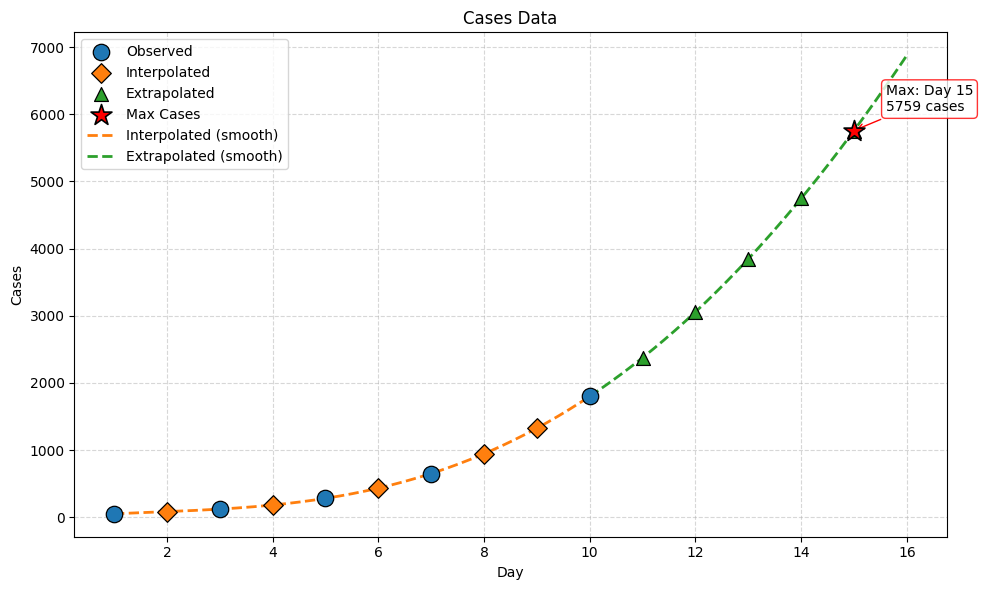

In [43]:
try:
    if cases.table is None:
        raise ValueError("No cases data available to plot")
    if cases.table.shape[0] <= 1:
        raise ValueError("Need at least 2 data points to plot cases")

    plt.figure(figsize=(10,6))

    # Integer days as points in the plot
    marker_map = {'Observed': 'o', 'Interpolated': 'D', 'Extrapolated': '^'}
    color_map = {'Observed': 'C0', 'Interpolated': 'C1', 'Extrapolated': 'C2'}
    size_map = {'Observed': 140, 'Interpolated': 100, 'Extrapolated': 100}

    for src in ['Observed', 'Interpolated', 'Extrapolated']:
        subset = cases.table[cases.table['Source'] == src]
        plt.scatter(subset['Day'], subset['Cases'],
                    marker=marker_map[src],
                    s=size_map[src],
                    c=color_map[src],
                    edgecolor='k',
                    linewidth=0.9,
                    label=f'{src}',
                    zorder=6)
        
    # Mark the day with the greatest number of cases
    idx_max = cases.table['Cases'].idxmax()
    max_row = cases.table.loc[idx_max]
    day_max = float(max_row['Day'])
    cases_max = float(max_row['Cases'])
    plt.scatter(day_max, cases_max, marker='*', s=250, c='red', edgecolor='k', linewidth=1.2, zorder=11, label='Max Cases')
    plt.annotate(f"Max: Day {int(round(day_max))}\n{cases_max:.0f} cases",
                    xy=(day_max, cases_max),
                    xytext=(day_max + 0.6, cases_max * 1.05 if cases_max>0 else cases_max + 1),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8))

    # Generate points in between the integer days
    cases.interpolate(fine = 300)
    cases.extrapolate(fine = 300, extend = 1.6)

    # Smooth interpolated curve
    x_interp = cases.table[cases.table['Source'] == 'Interpolated (smooth)']['Day']
    y_smooth_interp = np.atleast_1d(cases.table[cases.table['Source'] == 'Interpolated (smooth)']['Cases'])
    plt.plot(x_interp, y_smooth_interp, label='Interpolated (smooth)', linestyle='--', c='C1', linewidth=2, zorder=3)

    # Smooth extrapolated curve
    x_extrap = cases.table[cases.table['Source'] == 'Extrapolated (smooth)']['Day']
    y_smooth_extrap = np.atleast_1d(cases.table[cases.table['Source'] == 'Extrapolated (smooth)']['Cases'])
    plt.plot(x_extrap, y_smooth_extrap, label='Extrapolated (smooth)', linestyle='--', c='C2', linewidth=2, zorder=2)

    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.title('Cases Data')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print("Cannot plot cases data")
    print(f"[{e}]")

### 7.2 Deaths Data Visualization

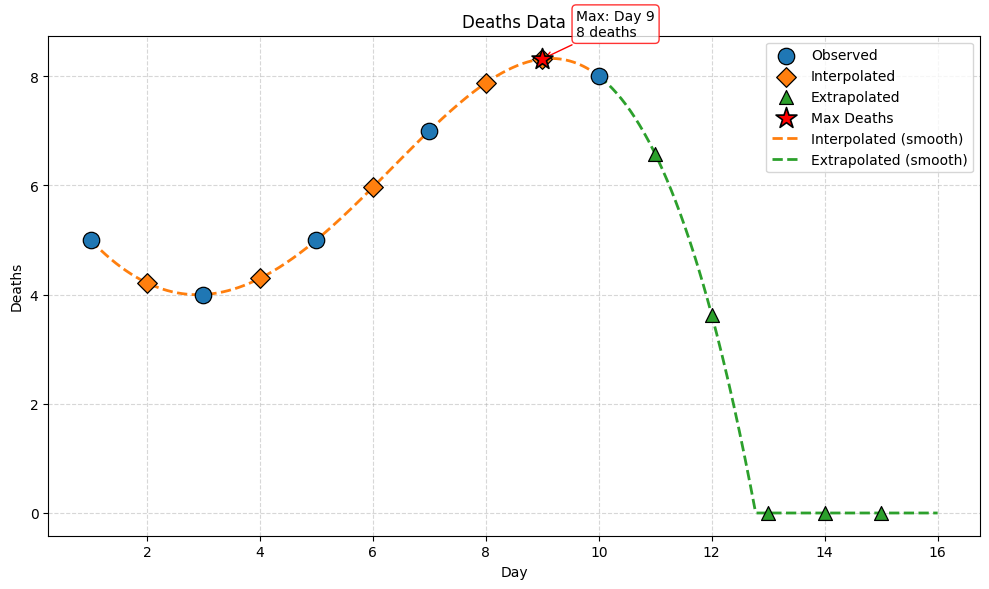

In [44]:
try:
    if deaths.table is None:
        raise ValueError("No deaths data available to plot")
    if deaths.table.shape[0] <= 1:
        raise ValueError("Need at least 2 data points to plot deaths")

    plt.figure(figsize=(10,6))

    # Integer days as points in the plot
    marker_map = {'Observed': 'o', 'Interpolated': 'D', 'Extrapolated': '^'}
    color_map = {'Observed': 'C0', 'Interpolated': 'C1', 'Extrapolated': 'C2'}
    size_map = {'Observed': 140, 'Interpolated': 100, 'Extrapolated': 100}

    for src in ['Observed', 'Interpolated', 'Extrapolated']:
        subset = deaths.table[deaths.table['Source'] == src]
        plt.scatter(subset['Day'], subset['Deaths'],
                    marker=marker_map[src],
                    s=size_map[src],
                    c=color_map[src],
                    edgecolor='k',
                    linewidth=0.9,
                    label=f'{src}',
                    zorder=6)
        
    # Mark the day with the greatest number of deaths
    idx_max = deaths.table['Deaths'].idxmax()
    max_row = deaths.table.loc[idx_max]
    day_max = float(max_row['Day'])
    deaths_max = float(max_row['Deaths'])
    plt.scatter(day_max, deaths_max, marker='*', s=250, c='red', edgecolor='k', linewidth=1.2, zorder=11, label='Max Deaths')
    plt.annotate(f"Max: Day {int(round(day_max))}\n{deaths_max:.0f} deaths",
                    xy=(day_max, deaths_max),
                    xytext=(day_max + 0.6, deaths_max * 1.05 if deaths_max>0 else deaths_max + 1),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8))
    
    # Generate points in between the integer days
    deaths.interpolate(fine = 300)
    deaths.extrapolate(fine = 300, extend = 1.6)

    # Smooth interpolated curve
    x_interp = deaths.table[deaths.table['Source'] == 'Interpolated (smooth)']['Day']
    y_smooth_interp = np.atleast_1d(deaths.table[deaths.table['Source'] == 'Interpolated (smooth)']['Deaths'])
    plt.plot(x_interp, y_smooth_interp, label='Interpolated (smooth)', linestyle='--', c='C1', linewidth=2, zorder=3)
    
    # Smooth extrapolated curve
    x_extrap = deaths.table[deaths.table['Source'] == 'Extrapolated (smooth)']['Day']
    y_smooth_extrap = np.atleast_1d(deaths.table[deaths.table['Source'] == 'Extrapolated (smooth)']['Deaths'])
    plt.plot(x_extrap, y_smooth_extrap, label='Extrapolated (smooth)', linestyle='--', c='C2', linewidth=2, zorder=2)
    
    plt.xlabel('Day')
    plt.ylabel('Deaths')
    plt.title('Deaths Data')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Cannot plot deaths data")
    print(f"[{e}]")


## 8. Overall Forecasting Confidence

This section provides guidance on how to interpret the results of interpolation and extrapolation in the disease outbreak predictor. The confidence in predictions varies depending on whether the estimation is within the observed data range or extends beyond it.

### 8.1. Interpolation Inside Observed Range (High Confidence)
- Interpolation is used to estimate values on days **between observed data points**.  
- Since it relies solely on existing data, the predicted values are generally accurate.  
- Errors and uncertainty are **relatively small and stable**, making this method highly reliable for filling missing data.

### 8.2. Short-Term Extrapolation (Moderate Confidence)
- Extrapolation predicts values **slightly beyond the last observed day**.  
- These predictions are reasonable for a **few days into the future**, assuming trends continue similarly.  
- Error margins increase compared to interpolation, so results should be treated as **rough forecasts** rather than precise values.

### 8.3. Long-Term Extrapolation (Low Confidence)
- Predictions **far beyond the observed time range** become highly uncertain.  
- Real-world outbreaks are influenced by dynamic factors such as interventions, behavior changes, or new variants, which are **not captured by a simple polynomial model**.  
- Long-term extrapolated values should be used with caution and primarily for **trend visualization** rather than exact planning.